In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [6]:
X, y = skds.fetch_openml("diabetes", return_X_y=True)
X = StandardScaler().fit_transform(X)


/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/sklearn/datasets/_openml.py:372: UserWarning: Multiple active versions of the dataset matching the name diabetes exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


In [7]:
y[y==['tested_positive']] = 1
y[y==['tested_negative']] = 0

In [8]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(500, 8)
(268, 8)


In [9]:
indices=np.arange(250)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:250]
x_train=np.concatenate((np.array(x_neg[0:250])[indices],x_pos)).reshape(-1,8)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [10]:
x_test = x_neg[250:500].reshape(-1,8)
y_test = y_neg[250:500].reshape(-1,1)

# Standard Bloom Filter

In [11]:
from bitarray import bitarray
import mmh3
import random
import numpy as np
import math

In [12]:
class BloomFilter:
    
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        
    def add(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            self.bit_array[result] = 1
            
    def lookup(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            if self.bit_array[result] == 0:
                return False
        return True

# Projection model

In [20]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [21]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times,standard_times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start1 = timeit.default_timer()
        
        stanbf = BloomFilter(m,k)
        for x_pos_i in x_pos:
            stanbf.add(sum(x_pos_i))
        
        stop1 = timeit.default_timer()
        
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create Standard: %f - Time Taken to create Projecion: %f \n\n\n" % (m,fpr_test,stop1-start1,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]
        standard_times += [stop1-start1]

In [23]:
num_of_iterations = 5 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []
standard_times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times,standard_times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(268, 8)
Size: 10 Bits - FPR: 0.988000 - Time Taken to create Standard: 0.002002 - Time Taken to create Projecion: 0.251428 



Size: 20 Bits - FPR: 0.836000 - Time Taken to create Standard: 0.001595 - Time Taken to create Projecion: 0.155436 



Size: 30 Bits - FPR: 0.872000 - Time Taken to create Standard: 0.001155 - Time Taken to create Projecion: 0.170074 



Size: 40 Bits - FPR: 0.884000 - Time Taken to create Standard: 0.001462 - Time Taken to create Projecion: 0.141705 



Size: 50 Bits - FPR: 0.808000 - Time Taken to create Standard: 0.001234 - Time Taken to create Projecion: 0.169289 



Size: 60 Bits - FPR: 0.852000 - Time Taken to create Standard: 0.003884 - Time Taken to create Projecion: 0.309935 



Size: 70 Bits - FPR: 0.824000 - Time Taken to create Standard: 0.009494 - Time Taken to create Projecion: 0.409314 



Size: 80 Bits - FPR: 0.756000 - Time Taken to create Standard: 0.001142 - Time Taken to create Projecion: 0.158578 



Size: 9

Size: 710 Bits - FPR: 0.348000 - Time Taken to create Standard: 0.001153 - Time Taken to create Projecion: 0.153964 



Size: 720 Bits - FPR: 0.280000 - Time Taken to create Standard: 0.001251 - Time Taken to create Projecion: 0.138061 



Size: 730 Bits - FPR: 0.316000 - Time Taken to create Standard: 0.001373 - Time Taken to create Projecion: 0.146737 



Size: 740 Bits - FPR: 0.252000 - Time Taken to create Standard: 0.002107 - Time Taken to create Projecion: 0.136399 



Size: 750 Bits - FPR: 0.244000 - Time Taken to create Standard: 0.002945 - Time Taken to create Projecion: 0.136712 



Size: 760 Bits - FPR: 0.340000 - Time Taken to create Standard: 0.002135 - Time Taken to create Projecion: 0.150388 



Size: 770 Bits - FPR: 0.212000 - Time Taken to create Standard: 0.002148 - Time Taken to create Projecion: 0.147246 



Size: 780 Bits - FPR: 0.284000 - Time Taken to create Standard: 0.002976 - Time Taken to create Projecion: 0.201239 



Size: 790 Bits - FPR: 0.264000 - Time Ta

Size: 1390 Bits - FPR: 0.100000 - Time Taken to create Standard: 0.006642 - Time Taken to create Projecion: 0.300370 



Size: 1400 Bits - FPR: 0.112000 - Time Taken to create Standard: 0.003307 - Time Taken to create Projecion: 0.291813 



Size: 1410 Bits - FPR: 0.096000 - Time Taken to create Standard: 0.002940 - Time Taken to create Projecion: 0.188671 



Size: 1420 Bits - FPR: 0.172000 - Time Taken to create Standard: 0.002766 - Time Taken to create Projecion: 0.190317 



Size: 1430 Bits - FPR: 0.144000 - Time Taken to create Standard: 0.002363 - Time Taken to create Projecion: 0.178003 



Size: 1440 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.004249 - Time Taken to create Projecion: 0.271391 



Size: 1450 Bits - FPR: 0.100000 - Time Taken to create Standard: 0.002614 - Time Taken to create Projecion: 0.265246 



Size: 1460 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.002022 - Time Taken to create Projecion: 0.185605 



Size: 1470 Bits - FPR: 0.092000 

Size: 2070 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.009999 - Time Taken to create Projecion: 0.782793 



Size: 2080 Bits - FPR: 0.060000 - Time Taken to create Standard: 0.006453 - Time Taken to create Projecion: 0.489132 



Size: 2090 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.005028 - Time Taken to create Projecion: 0.253051 



Size: 2100 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.002996 - Time Taken to create Projecion: 0.240830 



Size: 2110 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.004414 - Time Taken to create Projecion: 0.238840 



Size: 2120 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.003295 - Time Taken to create Projecion: 0.346828 



Size: 2130 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.003782 - Time Taken to create Projecion: 0.225679 



Size: 2140 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003725 - Time Taken to create Projecion: 0.256080 



Size: 2150 Bits - FPR: 0.076000 

Size: 2750 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.009346 - Time Taken to create Projecion: 0.449557 



Size: 2760 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.005815 - Time Taken to create Projecion: 0.329667 



Size: 2770 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.019436 - Time Taken to create Projecion: 0.458860 



Size: 2780 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.005015 - Time Taken to create Projecion: 0.702739 



Size: 2790 Bits - FPR: 0.008000 - Time Taken to create Standard: 0.009822 - Time Taken to create Projecion: 0.559636 



Size: 2800 Bits - FPR: 0.004000 - Time Taken to create Standard: 0.005507 - Time Taken to create Projecion: 0.766683 



Size: 2810 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.024242 - Time Taken to create Projecion: 0.579102 



Size: 2820 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.004240 - Time Taken to create Projecion: 0.445362 



Size: 2830 Bits - FPR: 0.028000 

Size: 430 Bits - FPR: 0.488000 - Time Taken to create Standard: 0.001203 - Time Taken to create Projecion: 0.444478 



Size: 440 Bits - FPR: 0.392000 - Time Taken to create Standard: 0.011932 - Time Taken to create Projecion: 1.022579 



Size: 450 Bits - FPR: 0.376000 - Time Taken to create Standard: 0.005033 - Time Taken to create Projecion: 0.635765 



Size: 460 Bits - FPR: 0.400000 - Time Taken to create Standard: 0.002461 - Time Taken to create Projecion: 0.342955 



Size: 470 Bits - FPR: 0.328000 - Time Taken to create Standard: 0.008079 - Time Taken to create Projecion: 1.234619 



Size: 480 Bits - FPR: 0.384000 - Time Taken to create Standard: 0.002545 - Time Taken to create Projecion: 0.670052 



Size: 490 Bits - FPR: 0.296000 - Time Taken to create Standard: 0.001732 - Time Taken to create Projecion: 0.846447 



Size: 500 Bits - FPR: 0.388000 - Time Taken to create Standard: 0.003372 - Time Taken to create Projecion: 0.290859 



Size: 510 Bits - FPR: 0.388000 - Time Ta

Size: 1120 Bits - FPR: 0.152000 - Time Taken to create Standard: 0.003447 - Time Taken to create Projecion: 0.295684 



Size: 1130 Bits - FPR: 0.128000 - Time Taken to create Standard: 0.013039 - Time Taken to create Projecion: 0.367150 



Size: 1140 Bits - FPR: 0.128000 - Time Taken to create Standard: 0.019582 - Time Taken to create Projecion: 0.481721 



Size: 1150 Bits - FPR: 0.120000 - Time Taken to create Standard: 0.013847 - Time Taken to create Projecion: 0.303580 



Size: 1160 Bits - FPR: 0.128000 - Time Taken to create Standard: 0.004294 - Time Taken to create Projecion: 0.424357 



Size: 1170 Bits - FPR: 0.164000 - Time Taken to create Standard: 0.010920 - Time Taken to create Projecion: 0.479264 



Size: 1180 Bits - FPR: 0.164000 - Time Taken to create Standard: 0.016274 - Time Taken to create Projecion: 0.415450 



Size: 1190 Bits - FPR: 0.132000 - Time Taken to create Standard: 0.004778 - Time Taken to create Projecion: 0.686531 



Size: 1200 Bits - FPR: 0.156000 

Size: 1800 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.019165 - Time Taken to create Projecion: 0.978312 



Size: 1810 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.062803 - Time Taken to create Projecion: 0.854431 



Size: 1820 Bits - FPR: 0.060000 - Time Taken to create Standard: 0.005011 - Time Taken to create Projecion: 0.475443 



Size: 1830 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.006989 - Time Taken to create Projecion: 0.929710 



Size: 1840 Bits - FPR: 0.060000 - Time Taken to create Standard: 0.026710 - Time Taken to create Projecion: 1.364673 



Size: 1850 Bits - FPR: 0.048000 - Time Taken to create Standard: 0.008412 - Time Taken to create Projecion: 0.748515 



Size: 1860 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.026163 - Time Taken to create Projecion: 0.926156 



Size: 1870 Bits - FPR: 0.052000 - Time Taken to create Standard: 0.011866 - Time Taken to create Projecion: 0.889200 



Size: 1880 Bits - FPR: 0.052000 

Size: 2480 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.007479 - Time Taken to create Projecion: 0.494524 



Size: 2490 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.008173 - Time Taken to create Projecion: 0.584136 



Size: 2500 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.009563 - Time Taken to create Projecion: 0.418706 



Size: 2510 Bits - FPR: 0.004000 - Time Taken to create Standard: 0.004863 - Time Taken to create Projecion: 0.663501 



Size: 2520 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.010295 - Time Taken to create Projecion: 0.479617 



Size: 2530 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.009206 - Time Taken to create Projecion: 0.378988 



Size: 2540 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.007818 - Time Taken to create Projecion: 0.392640 



Size: 2550 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.009394 - Time Taken to create Projecion: 0.664906 



Size: 2560 Bits - FPR: 0.012000 

Size: 160 Bits - FPR: 0.596000 - Time Taken to create Standard: 0.001163 - Time Taken to create Projecion: 0.476949 



Size: 170 Bits - FPR: 0.592000 - Time Taken to create Standard: 0.001581 - Time Taken to create Projecion: 0.647513 



Size: 180 Bits - FPR: 0.532000 - Time Taken to create Standard: 0.005704 - Time Taken to create Projecion: 0.384038 



Size: 190 Bits - FPR: 0.636000 - Time Taken to create Standard: 0.003552 - Time Taken to create Projecion: 0.222199 



Size: 200 Bits - FPR: 0.648000 - Time Taken to create Standard: 0.001325 - Time Taken to create Projecion: 0.255754 



Size: 210 Bits - FPR: 0.556000 - Time Taken to create Standard: 0.002774 - Time Taken to create Projecion: 0.301467 



Size: 220 Bits - FPR: 0.548000 - Time Taken to create Standard: 0.002957 - Time Taken to create Projecion: 0.265865 



Size: 230 Bits - FPR: 0.620000 - Time Taken to create Standard: 0.001334 - Time Taken to create Projecion: 0.233828 



Size: 240 Bits - FPR: 0.564000 - Time Ta

Size: 850 Bits - FPR: 0.200000 - Time Taken to create Standard: 0.002246 - Time Taken to create Projecion: 0.314898 



Size: 860 Bits - FPR: 0.220000 - Time Taken to create Standard: 0.010852 - Time Taken to create Projecion: 0.570038 



Size: 870 Bits - FPR: 0.196000 - Time Taken to create Standard: 0.003445 - Time Taken to create Projecion: 0.479203 



Size: 880 Bits - FPR: 0.180000 - Time Taken to create Standard: 0.018661 - Time Taken to create Projecion: 0.449061 



Size: 890 Bits - FPR: 0.236000 - Time Taken to create Standard: 0.009890 - Time Taken to create Projecion: 0.368377 



Size: 900 Bits - FPR: 0.184000 - Time Taken to create Standard: 0.002139 - Time Taken to create Projecion: 0.416639 



Size: 910 Bits - FPR: 0.196000 - Time Taken to create Standard: 0.002401 - Time Taken to create Projecion: 0.396956 



Size: 920 Bits - FPR: 0.140000 - Time Taken to create Standard: 0.010327 - Time Taken to create Projecion: 0.331777 



Size: 930 Bits - FPR: 0.240000 - Time Ta

Size: 1530 Bits - FPR: 0.144000 - Time Taken to create Standard: 0.002260 - Time Taken to create Projecion: 0.180518 



Size: 1540 Bits - FPR: 0.104000 - Time Taken to create Standard: 0.002136 - Time Taken to create Projecion: 0.199743 



Size: 1550 Bits - FPR: 0.132000 - Time Taken to create Standard: 0.005017 - Time Taken to create Projecion: 0.203044 



Size: 1560 Bits - FPR: 0.096000 - Time Taken to create Standard: 0.003822 - Time Taken to create Projecion: 0.233808 



Size: 1570 Bits - FPR: 0.088000 - Time Taken to create Standard: 0.002570 - Time Taken to create Projecion: 0.191874 



Size: 1580 Bits - FPR: 0.112000 - Time Taken to create Standard: 0.002958 - Time Taken to create Projecion: 0.200732 



Size: 1590 Bits - FPR: 0.068000 - Time Taken to create Standard: 0.003275 - Time Taken to create Projecion: 0.267115 



Size: 1600 Bits - FPR: 0.076000 - Time Taken to create Standard: 0.002571 - Time Taken to create Projecion: 0.240919 



Size: 1610 Bits - FPR: 0.120000 

Size: 2210 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.005112 - Time Taken to create Projecion: 0.252999 



Size: 2220 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.004795 - Time Taken to create Projecion: 0.299693 



Size: 2230 Bits - FPR: 0.064000 - Time Taken to create Standard: 0.004721 - Time Taken to create Projecion: 0.263618 



Size: 2240 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.004013 - Time Taken to create Projecion: 0.269933 



Size: 2250 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.005048 - Time Taken to create Projecion: 0.222719 



Size: 2260 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.003176 - Time Taken to create Projecion: 0.307767 



Size: 2270 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.006146 - Time Taken to create Projecion: 0.237717 



Size: 2280 Bits - FPR: 0.040000 - Time Taken to create Standard: 0.006953 - Time Taken to create Projecion: 0.253548 



Size: 2290 Bits - FPR: 0.052000 

Size: 2890 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.005159 - Time Taken to create Projecion: 0.776049 



Size: 2900 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.039306 - Time Taken to create Projecion: 0.409263 



Size: 2910 Bits - FPR: 0.008000 - Time Taken to create Standard: 0.004189 - Time Taken to create Projecion: 0.379463 



Size: 2920 Bits - FPR: 0.004000 - Time Taken to create Standard: 0.009924 - Time Taken to create Projecion: 0.292864 



Size: 2930 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.013424 - Time Taken to create Projecion: 0.820862 



Size: 2940 Bits - FPR: 0.028000 - Time Taken to create Standard: 0.005960 - Time Taken to create Projecion: 0.824564 



Size: 2950 Bits - FPR: 0.008000 - Time Taken to create Standard: 0.029834 - Time Taken to create Projecion: 0.588483 



Size: 2960 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.008945 - Time Taken to create Projecion: 1.074893 



Size: 2970 Bits - FPR: 0.012000 

Size: 570 Bits - FPR: 0.364000 - Time Taken to create Standard: 0.002830 - Time Taken to create Projecion: 0.349505 



Size: 580 Bits - FPR: 0.320000 - Time Taken to create Standard: 0.001684 - Time Taken to create Projecion: 1.022103 



Size: 590 Bits - FPR: 0.408000 - Time Taken to create Standard: 0.003537 - Time Taken to create Projecion: 0.415243 



Size: 600 Bits - FPR: 0.356000 - Time Taken to create Standard: 0.002855 - Time Taken to create Projecion: 0.267157 



Size: 610 Bits - FPR: 0.276000 - Time Taken to create Standard: 0.002898 - Time Taken to create Projecion: 0.776526 



Size: 620 Bits - FPR: 0.400000 - Time Taken to create Standard: 0.006569 - Time Taken to create Projecion: 0.453432 



Size: 630 Bits - FPR: 0.324000 - Time Taken to create Standard: 0.002450 - Time Taken to create Projecion: 0.411129 



Size: 640 Bits - FPR: 0.340000 - Time Taken to create Standard: 0.002058 - Time Taken to create Projecion: 0.165747 



Size: 650 Bits - FPR: 0.380000 - Time Ta

Size: 1260 Bits - FPR: 0.128000 - Time Taken to create Standard: 0.005029 - Time Taken to create Projecion: 0.509559 



Size: 1270 Bits - FPR: 0.160000 - Time Taken to create Standard: 0.017692 - Time Taken to create Projecion: 0.443550 



Size: 1280 Bits - FPR: 0.096000 - Time Taken to create Standard: 0.004448 - Time Taken to create Projecion: 0.545202 



Size: 1290 Bits - FPR: 0.140000 - Time Taken to create Standard: 0.003201 - Time Taken to create Projecion: 0.764155 



Size: 1300 Bits - FPR: 0.100000 - Time Taken to create Standard: 0.010164 - Time Taken to create Projecion: 0.712678 



Size: 1310 Bits - FPR: 0.172000 - Time Taken to create Standard: 0.005324 - Time Taken to create Projecion: 1.120491 



Size: 1320 Bits - FPR: 0.084000 - Time Taken to create Standard: 0.009403 - Time Taken to create Projecion: 1.037842 



Size: 1330 Bits - FPR: 0.072000 - Time Taken to create Standard: 0.014789 - Time Taken to create Projecion: 0.784092 



Size: 1340 Bits - FPR: 0.112000 

Size: 1940 Bits - FPR: 0.048000 - Time Taken to create Standard: 0.004960 - Time Taken to create Projecion: 0.245236 



Size: 1950 Bits - FPR: 0.064000 - Time Taken to create Standard: 0.003080 - Time Taken to create Projecion: 0.375911 



Size: 1960 Bits - FPR: 0.056000 - Time Taken to create Standard: 0.012553 - Time Taken to create Projecion: 0.241868 



Size: 1970 Bits - FPR: 0.056000 - Time Taken to create Standard: 0.005098 - Time Taken to create Projecion: 0.270856 



Size: 1980 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.003231 - Time Taken to create Projecion: 0.334327 



Size: 1990 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.005408 - Time Taken to create Projecion: 0.234168 



Size: 2000 Bits - FPR: 0.048000 - Time Taken to create Standard: 0.003317 - Time Taken to create Projecion: 0.244422 



Size: 2010 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.003368 - Time Taken to create Projecion: 0.215843 



Size: 2020 Bits - FPR: 0.024000 

Size: 2620 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.006281 - Time Taken to create Projecion: 0.838065 



Size: 2630 Bits - FPR: 0.024000 - Time Taken to create Standard: 0.011038 - Time Taken to create Projecion: 0.655187 



Size: 2640 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.003602 - Time Taken to create Projecion: 0.400655 



Size: 2650 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.005152 - Time Taken to create Projecion: 0.344918 



Size: 2660 Bits - FPR: 0.036000 - Time Taken to create Standard: 0.006338 - Time Taken to create Projecion: 0.365632 



Size: 2670 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.004790 - Time Taken to create Projecion: 0.261573 



Size: 2680 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.003984 - Time Taken to create Projecion: 0.255924 



Size: 2690 Bits - FPR: 0.016000 - Time Taken to create Standard: 0.004060 - Time Taken to create Projecion: 0.297651 



Size: 2700 Bits - FPR: 0.016000 

Size: 310 Bits - FPR: 0.464000 - Time Taken to create Standard: 0.001102 - Time Taken to create Projecion: 0.120412 



Size: 320 Bits - FPR: 0.540000 - Time Taken to create Standard: 0.001493 - Time Taken to create Projecion: 0.110457 



Size: 330 Bits - FPR: 0.512000 - Time Taken to create Standard: 0.001098 - Time Taken to create Projecion: 0.127011 



Size: 340 Bits - FPR: 0.460000 - Time Taken to create Standard: 0.001153 - Time Taken to create Projecion: 0.470762 



Size: 350 Bits - FPR: 0.424000 - Time Taken to create Standard: 0.002319 - Time Taken to create Projecion: 0.113561 



Size: 360 Bits - FPR: 0.536000 - Time Taken to create Standard: 0.001518 - Time Taken to create Projecion: 0.109175 



Size: 370 Bits - FPR: 0.380000 - Time Taken to create Standard: 0.002057 - Time Taken to create Projecion: 0.136833 



Size: 380 Bits - FPR: 0.404000 - Time Taken to create Standard: 0.001870 - Time Taken to create Projecion: 0.131244 



Size: 390 Bits - FPR: 0.412000 - Time Ta

Size: 1000 Bits - FPR: 0.172000 - Time Taken to create Standard: 0.002074 - Time Taken to create Projecion: 0.176310 



Size: 1010 Bits - FPR: 0.180000 - Time Taken to create Standard: 0.002816 - Time Taken to create Projecion: 0.139126 



Size: 1020 Bits - FPR: 0.224000 - Time Taken to create Standard: 0.003732 - Time Taken to create Projecion: 0.146844 



Size: 1030 Bits - FPR: 0.156000 - Time Taken to create Standard: 0.001803 - Time Taken to create Projecion: 0.131905 



Size: 1040 Bits - FPR: 0.220000 - Time Taken to create Standard: 0.001697 - Time Taken to create Projecion: 0.181240 



Size: 1050 Bits - FPR: 0.168000 - Time Taken to create Standard: 0.001675 - Time Taken to create Projecion: 0.131022 



Size: 1060 Bits - FPR: 0.156000 - Time Taken to create Standard: 0.002323 - Time Taken to create Projecion: 0.127352 



Size: 1070 Bits - FPR: 0.172000 - Time Taken to create Standard: 0.001499 - Time Taken to create Projecion: 0.150434 



Size: 1080 Bits - FPR: 0.176000 

Size: 1690 Bits - FPR: 0.068000 - Time Taken to create Standard: 0.003573 - Time Taken to create Projecion: 0.177334 



Size: 1700 Bits - FPR: 0.076000 - Time Taken to create Standard: 0.003219 - Time Taken to create Projecion: 0.183487 



Size: 1710 Bits - FPR: 0.048000 - Time Taken to create Standard: 0.006469 - Time Taken to create Projecion: 0.175216 



Size: 1720 Bits - FPR: 0.056000 - Time Taken to create Standard: 0.003259 - Time Taken to create Projecion: 0.217899 



Size: 1730 Bits - FPR: 0.076000 - Time Taken to create Standard: 0.002903 - Time Taken to create Projecion: 0.359335 



Size: 1740 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.006742 - Time Taken to create Projecion: 0.485043 



Size: 1750 Bits - FPR: 0.064000 - Time Taken to create Standard: 0.004503 - Time Taken to create Projecion: 0.168755 



Size: 1760 Bits - FPR: 0.080000 - Time Taken to create Standard: 0.002565 - Time Taken to create Projecion: 0.418693 



Size: 1770 Bits - FPR: 0.072000 

Size: 2370 Bits - FPR: 0.044000 - Time Taken to create Standard: 0.004063 - Time Taken to create Projecion: 0.350282 



Size: 2380 Bits - FPR: 0.012000 - Time Taken to create Standard: 0.016707 - Time Taken to create Projecion: 0.275995 



Size: 2390 Bits - FPR: 0.056000 - Time Taken to create Standard: 0.003844 - Time Taken to create Projecion: 0.225415 



Size: 2400 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.005657 - Time Taken to create Projecion: 0.648188 



Size: 2410 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.005160 - Time Taken to create Projecion: 0.397468 



Size: 2420 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.006000 - Time Taken to create Projecion: 0.695937 



Size: 2430 Bits - FPR: 0.032000 - Time Taken to create Standard: 0.012847 - Time Taken to create Projecion: 0.919473 



Size: 2440 Bits - FPR: 0.020000 - Time Taken to create Standard: 0.050722 - Time Taken to create Projecion: 0.915200 



Size: 2450 Bits - FPR: 0.012000 

In [24]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [25]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


In [26]:
total_standard_times = len(standard_times)
average_standard_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += standard_times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_standard_times += [temp]
print(len(average_standard_times))

300


# Normal Bloom Filter Values

In [27]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [28]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

1500
[268]


# FPR Comparison between Projection Model and Normal Bloom Filter

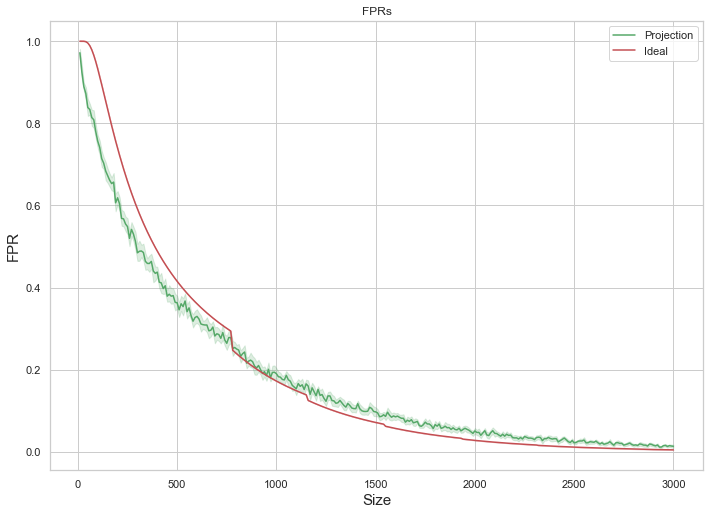

In [77]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [78]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

6000


In [79]:
average_times = num_of_iterations*average_times
print(len(average_times))

6000


In [80]:
print(average_fprs)

[0.9718, 0.9250000000000002, 0.8892, 0.8726, 0.8384, 0.8336, 0.8140000000000001, 0.8085999999999999, 0.7796000000000001, 0.7564, 0.7409999999999999, 0.7140000000000001, 0.7027999999999999, 0.6838, 0.6727999999999998, 0.6613999999999999, 0.6532, 0.6567999999999999, 0.6064, 0.6186, 0.6035999999999999, 0.5684, 0.5671999999999999, 0.5548000000000001, 0.5484, 0.5198, 0.5416000000000001, 0.53, 0.5124000000000002, 0.4846000000000001, 0.48840000000000006, 0.48900000000000005, 0.4854000000000001, 0.4638000000000001, 0.45879999999999993, 0.4586, 0.4635999999999999, 0.4402000000000001, 0.4346, 0.4376000000000001, 0.4130000000000001, 0.4114, 0.3976, 0.40440000000000004, 0.37900000000000006, 0.38380000000000003, 0.379, 0.38040000000000007, 0.36400000000000005, 0.36299999999999993, 0.34580000000000005, 0.3605999999999999, 0.3536, 0.36719999999999997, 0.3412, 0.3505999999999999, 0.33199999999999996, 0.31799999999999995, 0.32699999999999996, 0.3298, 0.32339999999999997, 0.3111999999999999, 0.309600000

In [29]:
saved_data = list(zip(size_values, y_ideal, standard_times, average_standard_times, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR','Standard Filter Total Creation Time(sec)', 'Average Standard Filter Total Creation Time(sec)', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Standard Filter Total Creation Time(sec),Average Standard Filter Total Creation Time(sec),Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,1.000000,0.002002,0.002707,0.988,0.9496,0.251428,0.396556
1,20,0.999999,0.001595,0.001981,0.836,0.9040,0.155436,0.409541
2,30,0.999887,0.001155,0.002060,0.872,0.9120,0.170074,0.399927
3,40,0.998870,0.001462,0.003138,0.884,0.8960,0.141705,0.318580
4,50,0.995548,0.001234,0.002730,0.808,0.8272,0.169289,0.296028


In [30]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/Diabetes_rerun_epochs_100.csv')